## Задание 1 (1 балл): Реализовать Tanh
Нужно реализовать функцию активации Tanh по аналогии с примерами выше

In [52]:
import numpy as np

class Tanh:
    def __init__(self):
        self.X = None

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.tanh(X)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        tanh_X = np.tanh(self.X)
        dYdX = 1 - tanh_X ** 2
        dLdx = dLdy * dYdX
        return dLdx

    def step(self, learning_rate):
        pass

In [53]:
tanh = Tanh()

X = np.array([[0.5, -1.0], [2.0, -2.0]])
out = tanh.forward(X)

# допустим, следующий слой вернул градиенты:
dLdy = np.ones_like(out)
dLdx = tanh.backward(dLdy)

print("Прямой проход:\n", out)
print("Обратный проход (grad):\n", dLdx)

Прямой проход:
 [[ 0.46211716 -0.76159416]
 [ 0.96402758 -0.96402758]]
Обратный проход (grad):
 [[0.78644773 0.41997434]
 [0.07065082 0.07065082]]


## Задание 2 (4 балла): Аугментации
Необходимо реализовать следующие преобразования (пример можно найти в лекции, также допускается использовать готовые варианты, например "from skimage.transform import rotate")
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности? Какие можно сделать выводы? (Сравнивать подходы можно по аналогии с тем, как это было проделано выше)

### Загрузка набора данных CelebA

Рассматривал dataset Celeba, т.к. матеарилы по аугментации разбирал по книге "Машинное обучение с pytorch и scikit-learn" (С. Рашка, Ю. Ли, В. Мирджалили). Глава 14.4.2. Преобразование изображений и дополнение данных.

Посчитаем количество изображений в каждом разделе (обучение, валидация, тестирование)

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch

In [55]:
image_path = "./"

celeba_train_dataset = torchvision.datasets.CelebA(
    image_path, split="train", target_type="attr", download=False
)

celeba_valid_dataset = torchvision.datasets.CelebA(
    image_path, split="valid", target_type="attr", download=False
)

celeba_test_dataset = torchvision.datasets.CelebA(
    image_path, split="test", target_type="attr", download=False
)

print('Обучение:', len(celeba_train_dataset))
print('Валидация:', len(celeba_valid_dataset))
print('Тесттирование:', len(celeba_test_dataset))

Обучение: 162770
Валидация: 19867
Тесттирование: 19962


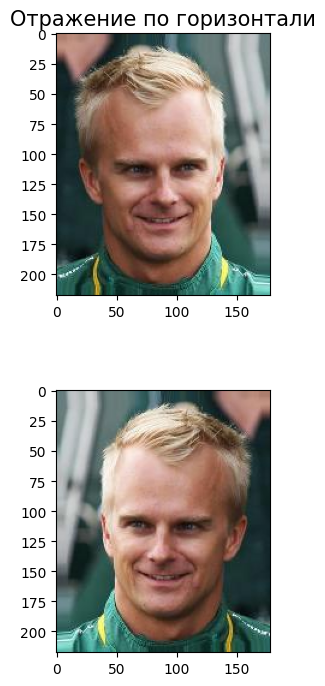

In [56]:
fig = plt.figure(figsize=(16,8.5))

ax = fig.add_subplot(2,5,2)
img, attr = celeba_train_dataset[12]
ax.set_title('Отражение по горизонтали', size = 15)
ax.imshow(img)
ax = fig.add_subplot(2,5,7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

In [57]:
# Приводим к одинаковому размеру и в тензор, применяя базовые трансформации
base_transform = transforms.Compose([
  transforms.CenterCrop(178),
  transforms.Resize([128,128]),
  transforms.ToTensor(),
])

# Вращения
rotation = transforms.Compose([
  transforms.CenterCrop(178),
  transforms.Resize([128,128]),
  transforms.RandomRotation(degrees=15,fill=0),
  transforms.ToTensor(),
])

# Сдвиги
shift = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize([128,128]),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), fill=0),  # ±10% по обеим осям
    transforms.ToTensor(),
])

# Зашумляем тензор
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.std + self.mean # независимый шум
        x = tensor + noise # добавили шум к изображению
        return torch.clamp(x, 0.0, 1.0) # возвращаем диапазон

noise = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize([128,128]),
    transforms.ToTensor(),
    AddGaussianNoise(0.0, 0.05),
])

#   - Комбинация всех трёх (порядок важен: геометрия до ToTensor, шум после)
combo = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize([128,128]),
    transforms.RandomRotation(15, fill=0),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), fill=0),
    transforms.ToTensor(),
    AddGaussianNoise(0.0, 0.05),
])

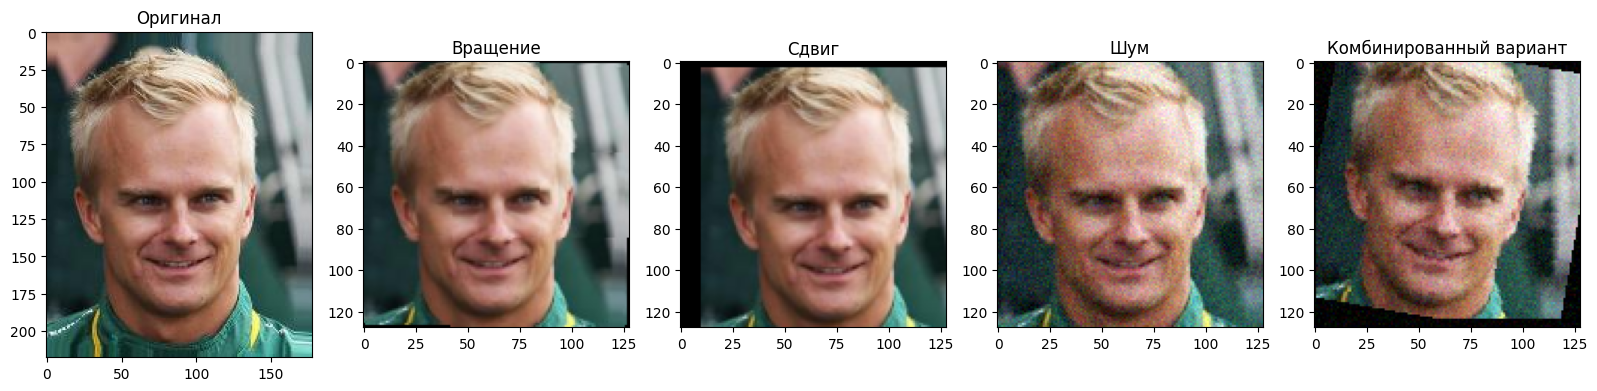

In [58]:
pil_img, attr = celeba_train_dataset[12]

fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(1, 5, 1)
ax.imshow(np.asarray(pil_img))
ax.set_title('Оригинал')

ax = fig.add_subplot(1, 5, 2)
ax.imshow(transforms.ToPILImage()(rotation(pil_img)))
ax.set_title('Вращение')

ax = fig.add_subplot(1, 5, 3)
ax.imshow(transforms.ToPILImage()(shift(pil_img)))
ax.set_title('Сдвиг')

ax = fig.add_subplot(1, 5, 4)
ax.imshow(transforms.ToPILImage()(noise(pil_img)))
ax.set_title('Шум')

ax = fig.add_subplot(1, 5, 5)
ax.imshow(transforms.ToPILImage()(combo(pil_img)))
ax.set_title('Комбинированный вариант')

plt.tight_layout()
plt.show()


### Сравнение подходов: учим одну и ту же модель с одинаковыми гиперпараметрами при разных трансформациях и сравниваем метрики.

In [59]:
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torch.optim import Adam
import random
from torch.utils.data import DataLoader, Subset

In [60]:
device = torch.device('cpu')
print("Device:", device)
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Device: cpu


In [61]:
trg_idx = 31
img_size = 64 # будем сжимать изображения
batch_size = 128
learning_rate  = 1e-3
epochs = 2

In [62]:
# перевод меток из -1;1 в 0;1 для бинарной кросс-энтропии
def convert_label(y_raw: torch.Tensor) -> torch.Tensor:
  return (y_raw.float() + 1)/2

##### Редактируем блок с transroms под задачу

In [63]:
# baseline (без аугм.)
base = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize([img_size, img_size]),
    transforms.ToTensor(),
])

# аугментации ТОЛЬКО для train:
rot = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize([img_size, img_size]),
    transforms.RandomRotation(15, fill=0),
    transforms.ToTensor(),
])

shift = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize([img_size, img_size]),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), fill=0),
    transforms.ToTensor(),
])

noise = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize([img_size, img_size]),
    transforms.ToTensor(),
    AddGaussianNoise(0.0, 0.03),
])

class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.03):
        self.mean, self.std = mean, std
    def __call__(self, t):
        n = torch.randn_like(t)*self.std + self.mean
        return torch.clamp(t + n, 0.0, 1.0)

combo = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize([img_size, img_size]),
    transforms.RandomRotation(15, fill=0),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), fill=0),
    transforms.ToTensor(),
    AddGaussianNoise(0.0, 0.03),
])

configs = {
    "baseline": base,
    "rot": rot,
    "shift": shift,
    "noise": noise,
    "combo": combo,
}

val_transform = base  # На валидации без аугментации

#### Подгруджаем данные

In [64]:
def make_loaders(transform_train, n_train=3000, n_val=1000, batch_size=128):
    train_full = torchvision.datasets.CelebA(
        root=image_path, split="train", target_type="attr", download=False, transform=transform_train
    )
    val_full = torchvision.datasets.CelebA(
        root=image_path, split="valid", target_type="attr", download=False, transform=val_transform
    )

    train_ds = Subset(train_full, range(min(n_train, len(train_full))))
    val_ds   = Subset(val_full,   range(min(n_val,   len(val_full))))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, val_loader

In [65]:
# Наследуем новый класс от базового класса всех моделей в PyTorch
# 256 нейронов на первый слой
# 128 нейронов на второй слой

class MLP(torch.nn.Module):
  def __init__(self, in_dim = 3*img_size*img_size, hidden_layers = (256,128)):
    super().__init__()

    self.layers = nn.Sequential(
      nn.Linear(in_dim, hidden_layers[0]),
      nn.Tanh(),
      nn.Linear(hidden_layers[0],hidden_layers[1]),
      nn.Tanh(),
      nn.Linear(hidden_layers[1],1)
    )

  def forward(self, x):
    # Раскладываем признаки в одномерный список
    x = x.view(x.size(0), -1) # (B, 3*64*64)
    logit = self.layers(x)
    return logit.squeeze(1)


#### Обучение одной эпохи без аугментации

In [66]:
# Один проход обучения (одна эпоха)
def train_one_epoch(model, loader, optimizer):
    total_loss = 0.0
    for imgs, attrs in loader:
        imgs = imgs.to(device)
        y = convert_label(attrs[:, trg_idx]).to(device)

        optimizer.zero_grad()
        logits = model.forward(imgs)
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    return total_loss / len(loader.dataset)  # средний loss по эпохе


# Оценка accuracy на валидации
@torch.no_grad()  # отключаем вычисление градиентов
def accuracy(model, loader):
    model.eval()
    all_preds, all_true = [], []  # метки
    for imgs, attrs in loader:
        imgs = imgs.to(device)
        y = convert_label(attrs[:, trg_idx]).cpu().numpy().astype(np.int32)
        logits = model.forward(imgs).cpu().numpy()  # (B,)
        probs = 1 / (1 + np.exp(-logits))  # сигмоида
        preds = (probs >= 0.5).astype(np.int32)
        all_preds.append(preds)
        all_true.append(y)
    preds = np.concatenate(all_preds)
    ys = np.concatenate(all_true)
    return accuracy_score(ys, preds)

In [67]:
EPOCHS = 5

results = {}
for name, tr in configs.items():
    print(f"\n=== {name} ===")
    train_loader, val_loader = make_loaders(tr, n_train=3000, n_val=1000, batch_size=128)

    model = MLP().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    best_val = 0.0
    best_state = None

    for ep in range(1, EPOCHS+1):
        tr_loss = train_one_epoch(model, train_loader, optimizer)
        va = accuracy(model, val_loader) # точность на валидации
        print(f"epoch {ep}: train_loss={tr_loss:.4f} | val_acc={va:.4f}")

    results[name] = va
    print(f"[{name}] best_val_acc={va:.4f}")

# Сводка и прирост к baseline
base_acc = results["baseline"]
print("\nИтог:")
for k, v in results.items():
    print(f"{k:9s}: {v:.4f} | прирост к baseline = {v - base_acc:+.4f}")


=== baseline ===
epoch 1: train_loss=0.6027 | val_acc=0.4860
epoch 2: train_loss=0.5723 | val_acc=0.4860
epoch 3: train_loss=0.5727 | val_acc=0.4860
epoch 4: train_loss=0.5721 | val_acc=0.4860
epoch 5: train_loss=0.5720 | val_acc=0.4860
[baseline] best_val_acc=0.4860

=== rot ===
epoch 1: train_loss=0.6175 | val_acc=0.4860
epoch 2: train_loss=0.5740 | val_acc=0.4860
epoch 3: train_loss=0.5717 | val_acc=0.4860
epoch 4: train_loss=0.5718 | val_acc=0.4860
epoch 5: train_loss=0.5717 | val_acc=0.4860
[rot] best_val_acc=0.4860

=== shift ===
epoch 1: train_loss=0.6124 | val_acc=0.4860
epoch 2: train_loss=0.5726 | val_acc=0.4860
epoch 3: train_loss=0.5718 | val_acc=0.4860
epoch 4: train_loss=0.5715 | val_acc=0.4860
epoch 5: train_loss=0.5722 | val_acc=0.4860
[shift] best_val_acc=0.4860

=== noise ===
epoch 1: train_loss=0.6133 | val_acc=0.4860
epoch 2: train_loss=0.5734 | val_acc=0.4860
epoch 3: train_loss=0.5721 | val_acc=0.4860
epoch 4: train_loss=0.5719 | val_acc=0.4860
epoch 5: train_los

### Вывод

В ходе работы была проведена оценка влияния аугментаций на качество классификации «улыбки» из датасета CelebA с использованием многослойного перцептрона (MLP).

Результаты показали, что при использовании MLP без пространственного понимания структуры изображения качество модели (val accuracy) оставалось неизменным (≈ 0.486) для всех вариантов аугментаций, включая базовый. Это значение совпадает с долей положительного класса на валидации, что свидетельствует о склонности модели предсказывать один класс.

Причиной отсутствия прироста качества является ограниченность архитектуры MLP: она не учитывает пространственные взаимосвязи между пикселями и не способна выделять локальные паттерны, важные для детекции улыбки. Аугментации, такие как поворот и сдвиг, актуальны только тогда, когда модель способна извлекать устойчивые пространственные признаки.

Таким образом, аугментация изображения целесообразна и эффективна при использовании архитектур, учитывающих геометрию, таких как CNN, и не даёт ощутимого прироста при применении MLP к сырым данным.